In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import tensorflow.keras.backend as K

from PIL import Image
from tqdm import tqdm
from tensorflow.keras.callbacks import ReduceLROnPlateau, LambdaCallback
from tensorflow.keras.layers import Lambda, Cropping2D, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

from torch.utils.data import Dataset, DataLoader

/home/bmatuszewki/Projects/_envs/default/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bmatuszewki/Projects/_envs/default/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bmatuszewki/Projects/_envs/default/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bmatuszewki/Projects/_

### Preview some images

In [2]:
def prepare_image_initial(path):
    img = np.array(cv2.imread(path)[:,:,::-1])
    return Image.fromarray(img)    

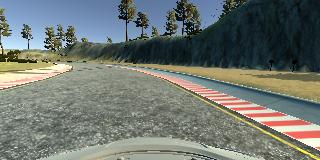

In [4]:
prepare_image_initial('./../_data/behavioral_cloning//good1/IMG/center_2019_10_30_09_35_55_229.jpg')

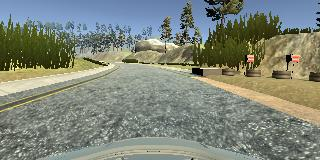

In [5]:
prepare_image_initial('./../_data/behavioral_cloning/good1/IMG/center_2019_10_30_09_36_25_490.jpg')

### Find eman image to determine Region Of Interest

100%|██████████| 3548/3548 [00:02<00:00, 1229.14it/s]


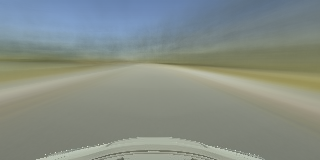

In [7]:
files = list(os.listdir('./../_data/behavioral_cloning/good1/IMG/'))
files = [ f for f in files if 'center' in f]

mean_img = np.zeros((160,320,3), dtype='long')
count = 0

with tqdm(total= len(files)) as p:
    for f in files:
        img = np.array(cv2.imread('./../_data/behavioral_cloning/good1/IMG/'+f)[:,:,::-1])
        mean_img += img
        count +=1
        p.update(1)
mean_img = mean_img // count
mean_img = mean_img.astype('uint8')
Image.fromarray(mean_img)

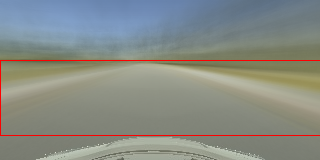

In [8]:
image_boundaries = mean_img.copy()
upper = 60
lower = 135
cv2.rectangle(image_boundaries,(0,upper),(320,lower), (255,0,0))
Image.fromarray(image_boundaries)

### Preview clipping result

In [9]:
def prepare_image(path):
    upper = 65
    lower = 135
    img = np.array(cv2.imread(path)[upper:lower,:,::-1])
    return Image.fromarray(img)
    

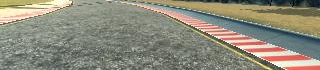

In [10]:
prepare_image('./../_data/behavioral_cloning/good1/IMG/center_2019_10_30_09_35_55_229.jpg')

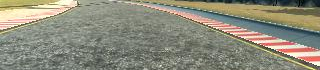

In [11]:
prepare_image('./../_data/behavioral_cloning/good1/IMG/left_2019_10_30_09_35_55_229.jpg')

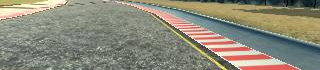

In [12]:
prepare_image('./../_data/behavioral_cloning/good1/IMG/right_2019_10_30_09_35_55_229.jpg')

In [13]:
def open_recording(folder_path):
    print("Reading:", folder_path)
    df = pd.read_csv(folder_path+'driving_log.csv', header=None)
    df.columns=['center','left','right','angle','throttle','break','speed']
    df['center'] = df['center'].apply(lambda x: x.split('/')[-1])
    df['left'] = df['left'].apply(lambda x: x.split('/')[-1])
    df['right'] = df['right'].apply(lambda x: x.split('/')[-1])
    df['path'] = [folder_path]*len(df)
    return df
    

In [14]:
df = open_recording('./../_data/behavioral_cloning/good1/')
df.head()

Reading: ./../_data/behavioral_cloning/good1/


,center,left,right,angle,throttle,break,speed,path
0,center_2019_10_30_09_35_55_229.jpg,left_2019_10_30_09_35_55_229.jpg,right_2019_10_30_09_35_55_229.jpg,0.00,0.0,0,1.806948,./../_data/behavioral_cloning/good1/
1,center_2019_10_30_09_35_55_304.jpg,left_2019_10_30_09_35_55_304.jpg,right_2019_10_30_09_35_55_304.jpg,0.00,0.0,0,1.791980,./../_data/behavioral_cloning/good1/
2,center_2019_10_30_09_35_55_419.jpg,left_2019_10_30_09_35_55_419.jpg,right_2019_10_30_09_35_55_419.jpg,0.00,0.0,0,1.769849,./../_data/behavioral_cloning/good1/
3,center_2019_10_30_09_35_55_486.jpg,left_2019_10_30_09_35_55_486.jpg,right_2019_10_30_09_35_55_486.jpg,0.00,0.0,0,1.758886,./../_data/behavioral_cloning/good1/
4,center_2019_10_30_09_35_55_566.jpg,left_2019_10_30_09_35_55_566.jpg,right_2019_10_30_09_35_55_566.jpg,-0.15,0.0,0,1.743292,./../_data/behavioral_cloning/good1/


Merge all recordings

In [16]:
df1 = open_recording('./../_data/behavioral_cloning/good1/')
df2 = open_recording('./../_data/behavioral_cloning/good2/')
#df3 = open_recording('./assets/good3o/')
df4 = open_recording('./../_data/behavioral_cloning/good4o/')

df = pd.concat([df1,df2,df4])

Reading: ./../_data/behavioral_cloning/good1/
Reading: ./../_data/behavioral_cloning/good2/
Reading: ./../_data/behavioral_cloning/good4o/


Check data histograms

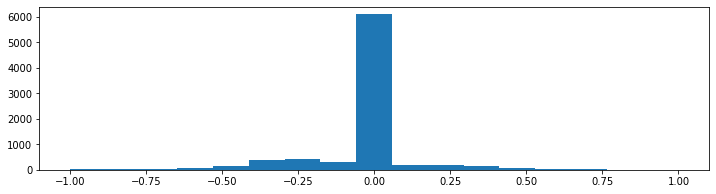

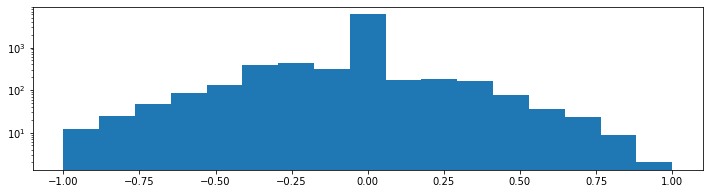

In [17]:
plt.figure(figsize=(12,3))
lin_hist = plt.hist(df['angle'], bins=17)
plt.figure(figsize=(12,3))
plt.hist(df['angle'], bins=17, log=True)
pass

In [18]:
from scipy.stats import norm
import math

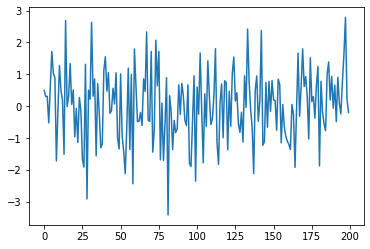

In [19]:
plt.plot(norm.rvs(loc=0,scale=1,size=200))

-0.030260149547166725 0.17551385956379997


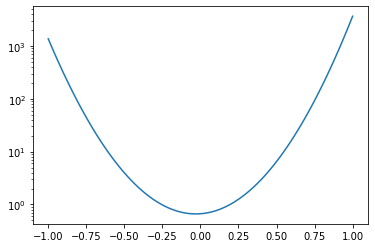

In [20]:
mu_x, std_x = norm.fit(df['angle'])
print(mu_x, std_x )
x_p = np.linspace(-1,1,100)
y_p = (1/std_x)*np.exp(-(((x_p-mu_x)/std_x)**2/2))/np.sqrt(2*(math.pi))

def get_weight_for_value(val, std_x, mu_x):
    y = (1/std_x)*np.exp(-(((val-mu_x)/std_x)**2/2))/np.sqrt(2*(math.pi))
    return 1/np.sqrt(y)
    
plt.plot(x_p, get_weight_for_value(x_p, std_x, mu_x))
plt.yscale("log")

Zero to non-zero angles

In [21]:
print("zero samples", len(df[df['angle']==0]))
print("non-zero samples", len(df[df['angle']!=0]))

zero samples 5841
non-zero samples 2358


# Dataset

In [22]:
class DrivingDataset(Dataset):
    def __init__(self, df):
        self.df= df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,index):
        row = self.df.iloc[index]
        path = row['path'] +'IMG/'
        img_l = cv2.imread(path+row['left'])[:,:,::-1]
        img_c = cv2.imread(path+row['center'])[:,:,::-1]
        img_r = cv2.imread(path+row['right'])[:,:,::-1]
        angle = row['angle']
        
        return np.float32(img_l), np.float32(img_c), np.float32(img_r), float(angle)

# Creating model

### Preprocessing of image

In [23]:
model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((65,25), (0,0)), input_shape=(160,320,3)))

optimizer = Adam(learning_rate=0.001)
loss = MSE
model.compile(optimizer, loss)

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d (Cropping2D)      (None, 70, 320, 3)        0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


Check preprocessing validity

In [25]:
sample_input = cv2.imread('./assets/good1/IMG/center_2019_10_30_09_35_55_229.jpg')[:,:,::-1]
sample_input = np.expand_dims(sample_input,axis=0)

TypeError: 'NoneType' object is not subscriptable

In [26]:
preds = model.predict(x=sample_input)
plt.imshow(preds[0]+0.5)

NameError: name 'sample_input' is not defined

### Summarizer

In [27]:
def create_bins(num, low=-1,high=1, eps=sys.float_info.epsilon):
    total_len = high-low
    each_size = total_len / num
    print(f"Degree of freedom: +/-{(each_size/2):0.3f}")
    
    bins = []
    
    for i in range(num):
        e = 0
        if i>0:
            e=eps
        l = low+each_size*i+e
        h = low+each_size*(i+1)
        bins.append((l,h))
    
    return np.array(bins)
    
create_bins(5) 

Degree of freedom: +/-0.200


array([[-1. , -0.6],
       [-0.6, -0.2],
       [-0.2,  0.2],
       [ 0.2,  0.6],
       [ 0.6,  1. ]])

In [292]:
def value_to_bin(bins, value):
    for i,b in enumerate(bins):
        if value <= b[1]:
            return i
    return len(bins)-1

value_to_bin(create_bins(5),0)

Degree of freedom: +/-0.200


2

In [337]:
class EpochSummarizer():
    def __init__(self, model, loader, categories = 7):
        self.model = model
        self.loader = loader
        self.data = {}
        self.epoch = 0
        self.bins = create_bins(categories)
        
    def summarize(self, epoch, logs):
        self.data[self.epoch] = []
        
        with tqdm(desc="Summary progress", total= len(self.loader), leave=False) as p:
            for idx,(img_l,img_c,img_r,angle) in enumerate(self.loader):
                pred = model.predict(img_c)[0]
                
                pred_bin = value_to_bin(self.bins, pred)
                angle_bin = value_to_bin(self.bins, angle)
                
                self.data[epoch].append( (pred, angle, pred_bin, angle_bin) )
                p.update()

        self.data[self.epoch] = np.array(self.data[self.epoch])
        self.accuracy(self.epoch)
        self.epoch += 1 
        
    def accuracy(self, epoch):
        data = self.data[epoch]
        
        for i,b in enumerate(self.bins):
            gt_selctor = data[:,3]==i
            nom = np.sum([data[gt_selctor][:,2]==i])
            dnom = np.sum(gt_selctor)
            acc = "n/a"
            if dnom>0:
                acc = f"{(nom/dnom):0.3f}"
            print(f"Accuracy in bin {i}({b[0]:0.3f}-{b[1]:0.3f}): {acc}", nom, dnom)

### (MODEL1) Simple model

In [338]:
model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((65,25), (0,0)), input_shape=(160,320,3)))
model.add(Conv2D(16,(3,3),padding='valid', activation='relu'))
model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
loss = MSE
model.compile(optimizer, loss)
model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_33 (Lambda)           (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_32 (Cropping2D)   (None, 70, 320, 3)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 68, 318, 16)       448       
_________________________________________________________________
global_average_pooling2d_24  (None, 16)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 17        
Total params: 465
Trainable params: 465
Non-trainable params: 0
_________________________________________________________________


In [339]:
dataset = DrivingDataset(df)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

def data_generator(ld, epochs):
    for e in range(epochs):
        for img_l,img_c,img_r,angle in ld:
            yield img_c, angle

In [340]:
epochs = 15
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=2, min_lr=0.00001, verbose=1)

epoch_summarizer = EpochSummarizer(model, data_loader)
summarize = LambdaCallback(on_epoch_end=lambda epoch,logs: epoch_summarizer.summarize(epoch, logs))

fit_result = model.fit_generator(data_generator(data_loader, epochs), 
                                 steps_per_epoch=len(data_loader), 
                                 epochs=epochs, 
                                 verbose=1,
                                 callbacks=[
                                         reduce_lr,
                                         summarize
                                         ])
plt.plot(fit_result.history['loss'])

Degree of freedom: +/-0.143
Epoch 1/15
8198/8199 [============================>.] - ETA: 0s - loss: 0.0372

Accuracy in bin 0(-1.000--0.714): 0.000 0 46
Accuracy in bin 1(-0.714--0.429): 0.000 0 237
Accuracy in bin 2(-0.429--0.143): 0.000 0 1086
Accuracy in bin 3(-0.143-0.143): 1.000 6222 6222
Accuracy in bin 4(0.143-0.429): 0.000 0 467
Accuracy in bin 5(0.429-0.714): 0.000 0 124
Accuracy in bin 6(0.714-1.000): 0.000 0 17
8199/8199 [==============================] - 133s 16ms/step - loss: 0.0372


Epoch 2/15
8195/8199 [============================>.] - ETA: 0s - loss: 0.0317

Accuracy in bin 0(-1.000--0.714): 0.000 0 46
Accuracy in bin 1(-0.714--0.429): 0.000 0 237
Accuracy in bin 2(-0.429--0.143): 0.000 0 1086
Accuracy in bin 3(-0.143-0.143): 1.000 6222 6222
Accuracy in bin 4(0.143-0.429): 0.000 0 467
Accuracy in bin 5(0.429-0.714): 0.000 0 124
Accuracy in bin 6(0.714-1.000): 0.000 0 17
8199/8199 [==============================] - 132s 16ms/step - loss: 0.0317
Epoch 3/15
   1/8199 [..............................] - ETA: 1:32 - loss: 1.2937e-13

8194/8199 [============================>.] - ETA: 0s - loss: 0.0317

Accuracy in bin 0(-1.000--0.714): 0.000 0 46
Accuracy in bin 1(-0.714--0.429): 0.000 0 237
Accuracy in bin 2(-0.429--0.143): 0.000 0 1086
Accuracy in bin 3(-0.143-0.143): 1.000 6222 6222
Accuracy in bin 4(0.143-0.429): 0.000 0 467
Accuracy in bin 5(0.429-0.714): 0.000 0 124
Accuracy in bin 6(0.714-1.000): 0.000 0 17
8199/8199 [==============================] - 133s 16ms/step - loss: 0.0317
Epoch 4/15
   1/8199 [..............................] - ETA: 1:52 - loss: 0.2500

8195/8199 [============================>.] - ETA: 0s - loss: 0.0317

Summary progress:   0%|          | 25/8199 [00:00<01:08, 119.95it/s]


Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.


Accuracy in bin 0(-1.000--0.714): 0.000 0 46
Accuracy in bin 1(-0.714--0.429): 0.000 0 237
Accuracy in bin 2(-0.429--0.143): 0.000 0 1086
Accuracy in bin 3(-0.143-0.143): 1.000 6222 6222
Accuracy in bin 4(0.143-0.429): 0.000 0 467
Accuracy in bin 5(0.429-0.714): 0.000 0 124
Accuracy in bin 6(0.714-1.000): 0.000 0 17
8199/8199 [==============================] - 134s 16ms/step - loss: 0.0317
Epoch 5/15
   1/8199 [..............................] - ETA: 1:15 - loss: 0.0000e+00

8198/8199 [============================>.] - ETA: 0s - loss: 0.0317

Accuracy in bin 0(-1.000--0.714): 0.000 0 46
Accuracy in bin 1(-0.714--0.429): 0.000 0 237
Accuracy in bin 2(-0.429--0.143): 0.000 0 1086
Accuracy in bin 3(-0.143-0.143): 1.000 6222 6222
Accuracy in bin 4(0.143-0.429): 0.000 0 467
Accuracy in bin 5(0.429-0.714): 0.000 0 124
Accuracy in bin 6(0.714-1.000): 0.000 0 17
8199/8199 [==============================] - 121s 15ms/step - loss: 0.0317
Epoch 6/15
   1/8199 [..............................] - ETA: 1:16 - loss: 0.0023

8198/8199 [============================>.] - ETA: 0s - loss: 0.0317

Summary progress:   0%|          | 0/8199 [00:00<?, ?it/s]


Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.


KeyboardInterrupt: 

### (MODEL2) weighted loss

In [479]:
std_x, mu_x

(0.17551385956379997, -0.030260149547166725)

In [480]:
def get_weight_for_value(val, std_x, mu_x):
    y = (1/std_x)*np.exp(-(((val-mu_x)/std_x)**2/2))/np.sqrt(2*(math.pi))
    return 1/np.sqrt(y)

def weighted_loss(y_true, y_pred):
    
    std_x = 0.1755
    mu_x = -0.0302
    
    weight = K.exp(-(((y_true-mu_x)/std_x)**2/2))
    
    return K.mean(K.square(y_pred - y_true)*weight, axis=-1)

model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((65,25), (0,0)), input_shape=(160,320,3)))
model.add(Conv2D(16,(3,3),padding='valid', activation='relu'))
model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
loss = weighted_loss
model.compile(optimizer, loss)
model.summary()



Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_36 (Lambda)           (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_35 (Cropping2D)   (None, 70, 320, 3)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 68, 318, 16)       448       
_________________________________________________________________
global_average_pooling2d_26  (None, 16)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 17        
Total params: 465
Trainable params: 465
Non-trainable params: 0
_________________________________________________________________


In [481]:
dataset = DrivingDataset(df)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

def data_generator(ld, epochs):
    for e in range(epochs):
        for img_l,img_c,img_r,angle in ld:
            yield img_c, angle

In [ ]:
epochs = 15
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=2, min_lr=0.00001, verbose=1)

epoch_summarizer = EpochSummarizer(model, data_loader)
summarize = LambdaCallback(on_epoch_end=lambda epoch,logs: epoch_summarizer.summarize(epoch, logs))

fit_result = model.fit_generator(data_generator(data_loader, epochs), 
                                 steps_per_epoch=len(data_loader), 
                                 epochs=epochs, 
                                 verbose=1,
                                 callbacks=[
                                         reduce_lr,
                                         summarize
                                         ])
plt.plot(fit_result.history['loss'])

Degree of freedom: +/-0.143
Epoch 1/15
8194/8199 [============================>.] - ETA: 0s - loss: 0.0069

Accuracy in bin 0(-1.000--0.714): 0.000 0 46
Accuracy in bin 1(-0.714--0.429): 0.000 0 237
Accuracy in bin 2(-0.429--0.143): 0.000 0 1086
Accuracy in bin 3(-0.143-0.143): 1.000 6222 6222
Accuracy in bin 4(0.143-0.429): 0.000 0 467
Accuracy in bin 5(0.429-0.714): 0.000 0 124
Accuracy in bin 6(0.714-1.000): 0.000 0 17
8199/8199 [==============================] - 145s 18ms/step - loss: 0.0069
Epoch 2/15
   1/8199 [..............................] - ETA: 2:05 - loss: 9.7234e-08

8197/8199 [============================>.] - ETA: 0s - loss: 0.0043

Accuracy in bin 0(-1.000--0.714): 0.000 0 46
Accuracy in bin 1(-0.714--0.429): 0.000 0 237
Accuracy in bin 2(-0.429--0.143): 0.000 0 1086
Accuracy in bin 3(-0.143-0.143): 1.000 6222 6222
Accuracy in bin 4(0.143-0.429): 0.000 0 467
Accuracy in bin 5(0.429-0.714): 0.000 0 124
Accuracy in bin 6(0.714-1.000): 0.000 0 17
8199/8199 [==============================] - 144s 18ms/step - loss: 0.0043


Epoch 3/15
6555/8199 [======================>.......] - ETA: 16s - loss: 0.0043